In [1]:
import pandas as pd  
from sklearn.preprocessing import  LabelEncoder  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier 



## 📊 Chargement et préparation des données

Avant d’entraîner un modèle de machine learning, il est essentiel de s'assurer que les données sont propres, cohérentes et prêtes à l'emploi. Le code ci-dessous présente une fonction permettant de charger et préparer les données à partir d'un fichier CSV.

### 🔍 Étapes de préparation

1. **Chargement des données** : Les données sont importées depuis un fichier CSV.
2. **Nettoyage** :
   - Suppression des doublons (`drop_duplicates()`).
   - Suppression des valeurs manquantes (`dropna()`).
3. **Suppression de colonnes inutiles** : Certaines colonnes jugées non pertinentes pour la prédiction sont supprimées si elles sont présentes dans les données. Par exemple :
   - `Date_de_remplissage_de_la_fiche`
   - `raison_indisponibilite`
4. **Séparation des variables** :
   - `X` : variables explicatives (features).
   - `y` : variable cible (`ÉLIGIBILITÉ_AU_DON.`).
5. **Encodage de la variable cible** : La variable `y` est encodée en valeurs numériques à l’aide de `LabelEncoder` pour être utilisée dans les algorithmes d’apprentissage automatique.

Ce processus garantit que les données sont prêtes à être utilisées pour l’entraînement et l’évaluation d’un modèle prédictif.

In [2]:
# Chargement des données
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    df = df.drop_duplicates().dropna()
    df = df.drop(columns=['Date_de_remplissage_de_la_fiche', 'raison_indisponibilite'], errors='ignore')
    
    # Séparation features/target
    X = df.drop('ÉLIGIBILITÉ_AU_DON.', axis=1)
    y = df['ÉLIGIBILITÉ_AU_DON.']
    
    return X, y

# Chargement
X, y = load_and_prepare_data('cleaned_data.csv')
# Label Encoding pour la cible
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convertir les labels en valeurs numériques
X.tail(20)


,Niveau_d'etude,Genre,Taille,Poids,Situation_Matrimoniale_(SM),Profession,Arrondissement_de_résidence,Quartier_de_Résidence,Nationalité,Religion,A-t-il_(elle)_déjà_donné_le_sang,Taux_d’hémoglobine,age
1895,Pas Précisé,Homme,1.874037,79.0,Marié (e),ELECTRICIEN,Douala 3,NDOGPOSSI,Camerounaise,CHRETIEN,Non,9.502808,45
1896,Secondaire,Homme,1.905885,79.0,Marié (e),ELECTRICIEN,Douala 3,BONAORISSO,Camerounaise,CHRETIEN,Oui,14.002373,54
1897,Universitaire,Femme,1.828239,91.0,Marié (e),CONTROLEUR DES DOUANES,Douala 3,LOGBABA,Camerounaise,CHRETIEN,Non,14.596375,32
1898,Universitaire,Homme,1.564048,80.0,Célibataire,ASSISTANT DE DIRECTION,Douala 5,VILLAGE,Camerounaise,CHRETIEN,Oui,14.400000,25
1899,Secondaire,Homme,1.669134,80.0,Marié (e),CASINO,Douala (Non précisé ),NEWTON AIRPORT,Camerounaise,CHRETIEN,Non,9.203897,61
1900,Universitaire,Homme,1.964042,81.0,Célibataire,ETUDIANT E,Douala 4,BONABERI,RAS,NON-RELIGIEUX,Non,14.900000,28
1901,Pas Précisé,Homme,1.612308,79.0,Marié (e),TECHNICIEN TOPO,Douala 3,NDOGPASSI 2,RAS,CHRETIEN,Non,14.002373,44
1902,Secondaire,Femme,1.686084,80.0,Célibataire,SANS EMPLOIS,Douala 5,PK10,Camerounaise,NON-RELIGIEUX,Non,6.462179,29
1903,Primaire,Femme,1.716038,79.0,Célibataire,MENAGERE,Douala 3,TEXACO AEROPORT,RAS,CHRETIEN,Oui,7.580950,44
1904,Secondaire,Homme,1.719702,79.0,Célibataire,FERRAILLEUR,Douala 3,YASSA,Camerounaise,NON-RELIGIEUX,Non,8.588693,30


## ⚙️ Construction du pipeline de machine learning

Dans cette section, nous mettons en place un pipeline de machine learning complet incluant le **prétraitement des données**, la gestion du **déséquilibre des classes**, et l'entraînement d'un **modèle de classification** avec optimisation des hyperparamètres.

### 🧪 Étapes du pipeline

1. **Séparation des colonnes**
   - Les colonnes numériques (`int64`, `float64`) et catégorielles (`object`) sont identifiées afin d’appliquer des traitements spécifiques à chacune.

2. **Prétraitement avec `ColumnTransformer`**
   - Les variables **numériques** sont normalisées avec `StandardScaler`.
   - Les variables **catégorielles** sont transformées via `OneHotEncoder` (avec `handle_unknown='ignore'` pour éviter les erreurs sur des catégories inédites).

3. **Pipeline global (`Pipeline`)** 
  - Le **préprocesseur** (`transformer`)
  - Le **classifieur XGBoost** (`XGBClassifier`)

4. **Séparation du jeu de données**
   - Le jeu de données est divisé en ensemble d'entraînement et de test (80% / 20%) avec `stratify=y` pour conserver la distribution des classes.

5. **Optimisation avec `GridSearchCV`**
   - Une grille de recherche est définie pour tester plusieurs combinaisons d'hyperparamètres du classifieur XGBoost.
   - La recherche utilise une validation croisée à 5 plis (`cv=5`) et l’**accuracy** comme métrique d’évaluation.

### 🎯 Objectif

Ce pipeline vise à automatiser l’ensemble du processus de traitement des données et d’entraînement du modèle, tout en s’assurant de la **robustesse** (via la validation croisée) et de la **performance** (via l’optimisation des hyperparamètres) du modèle final.

In [3]:
# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Définition des colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Prétraitement avec encodage des variables catégorielles
transformer = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline XGBoost
pipeline = Pipeline([
    ('preprocessor', transformer),
    ('classifier', XGBClassifier(random_state=42))
])

# Recherche d'hyperparamètres
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Taille', 'Poids', 'Taux_d’hémoglobine', 'age'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Niveau_d'etude', 'Genre', 'Situation_Matrimoniale_(SM)', 'Profession',
       'Arrondissement_de_résidence', 'Quartier_de_R...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='accuracy')

In [4]:
# Résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Score sur les données de test :", grid_search.score(X_test, y_test))

Meilleurs hyperparamètres : {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Score sur les données de test : 0.928695652173913


### 🧠 Interprétation

- Ce score élevé suggère que le modèle **généralise bien** sur de nouvelles données.
- La combinaison `max_depth = 3` et `n_estimators = 200` laisse penser que le modèle préfère des **arbres peu profonds mais nombreux**, une stratégie souvent efficace pour limiter le surapprentissage tout en conservant une bonne capacité prédictive.
- Pour évaluer plus finement la performance (notamment en cas de classes déséquilibrées), il est recommandé de compléter avec :
  - Le **rapport de classification** (précision, rappel, f1-score par classe)
  - La **matrice de confusion**
  - Des métriques globales comme l’**AUC (ROC)** par classe




## 🧾 Évaluation du modèle

Après l’entraînement du modèle avec les meilleurs hyperparamètres, nous procédons à son **évaluation** sur l’ensemble de test.

### ✅ Étapes d'évaluation

1. **Prédictions**
   - `y_pred` : prédictions de la classe cible pour les données de test.
   - `y_proba` : probabilités associées aux classes, utiles pour des métriques avancées ou des courbes ROC.

2. **Rapport de classification**
   - Affiche les métriques de performance par classe :
     - **Précision (precision)** : proportion de vraies prédictions positives parmi celles prédites comme positives.
     - **Rappel (recall)** : proportion de vraies prédictions positives parmi les observations réellement positives.
     - **F1-score** : moyenne harmonique entre précision et rappel.

3. **Matrice de confusion**
   - Représentation graphique du nombre de prédictions correctes et incorrectes.
   - Chaque cellule `[i, j]` montre le nombre d’échantillons de la **vraie classe i** prédits comme **classe j**.
   - Les étiquettes des classes sont personnalisées pour une meilleure lisibilité :
     - "Définitivement non-eligible"
     - "Eligible"
     - "Temporairement Non-eligible"

### 🎯 Objectif

Cette étape permet de **comparer les performances par classe**, de détecter d’éventuels déséquilibres ou erreurs de classification, et d’affiner les décisions futures concernant le modèle ou le traitement des données. 


Rapport de classification avec étiquettes :
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        28
           1       0.95      0.98      0.97       481
           2       0.85      0.77      0.81        66

    accuracy                           0.93       575
   macro avg       0.80      0.73      0.76       575
weighted avg       0.92      0.93      0.92       575



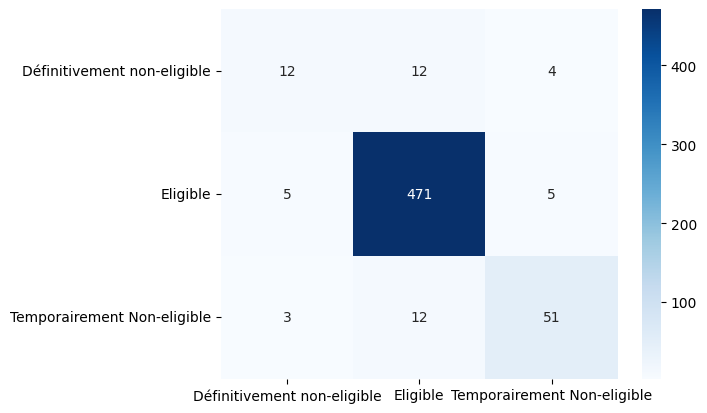

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
# Prédictions
y_pred = grid_search.best_estimator_.predict(X_test)
y_proba = grid_search.best_estimator_.predict_proba(X_test) 

# Afficher les résultats
print("\nRapport de classification avec étiquettes :")
print(classification_report(y_test, y_pred))

# Matrice de confusion avec étiquettes
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Définitivement non-eligible", "Eligible", "Temporairement Non-eligible"], yticklabels=["Définitivement non-eligible", "Eligible", "Temporairement Non-eligible"])
plt.show()


Voici un markdown clair et structuré pour interpréter ton **rapport de classification multiclasse** :

---

## 📊 Analyse du rapport de classification

### 📌 Définitions rapides
- **Précision** : parmi les prédictions faites pour une classe, combien sont correctes.
- **Rappel** : parmi les vraies instances d’une classe, combien ont été correctement prédites.
- **F1-score** : moyenne harmonique entre précision et rappel.
- **Support** : nombre réel d’instances de chaque classe dans les données de test.


### 🎯 Analyse par classe

- **Classe `Eligible` (majoritaire)** :  
  Le modèle performe **très bien** sur cette classe avec une **précision de 95%** et un **rappel de 98%**. C’est probablement la classe la plus représentée, ce qui facilite son apprentissage.

- **Classe `Temporairement Non-eligible`** :  
  Le modèle s’en sort **plutôt bien**, avec un bon équilibre entre **précision (85%)** et **rappel (77%)**. Quelques instances sont mal classées, mais globalement, la performance reste acceptable.

- **Classe `Définitivement non-eligible` (minoritaire)** :  
  Le modèle a plus de difficulté ici :  
  - Précision de **60%** : lorsqu’il prédit cette classe, il se trompe encore dans 40% des cas.  
  - Rappel de **43%** : il ne détecte que 43% des vrais cas de classe 0.  
  Cela peut s'expliquer par un **déséquilibre des classes** ou une **difficulté intrinsèque à caractériser cette classe**.



### 🧮 Performances globales 

- **Accuracy globale de 93%** : très bonne performance générale.
- **Macro average** : utile pour évaluer l’équité du modèle entre classes. La baisse du rappel à **0.73** met en lumière la difficulté à bien prédire les classes minoritaires.
- **Weighted average** : pondère les scores selon le support. Très bon score global, **mais reflète surtout la qualité sur la classe majoritaire**.


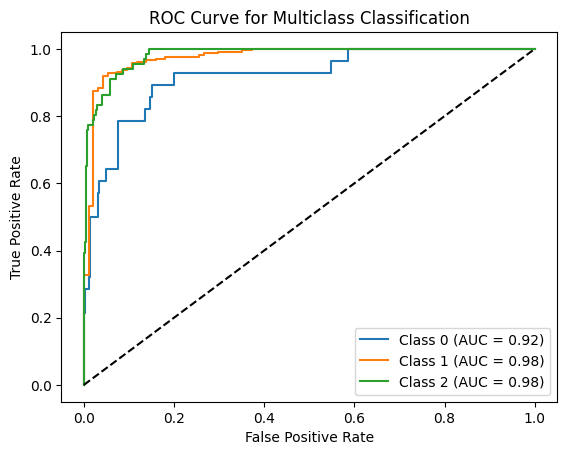

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes as per your labels
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()



## 🔍 Analyse des variables les plus importantes

### 📌 Objectif

Identifier les **caractéristiques les plus influentes** dans les prédictions du modèle `XGBoost`. Cela permet de mieux comprendre comment le modèle prend ses décisions, et peut orienter des actions concrètes ou une amélioration des données.



### 🧠 Méthodologie

- Le modèle final sélectionné (`XGBClassifier`) dispose d’un attribut `.feature_importances_` qui indique le **poids relatif** de chaque variable dans les décisions du modèle.
- Le préprocesseur (`ColumnTransformer`) applique une **transformation complète** des données (normalisation, encodage), ce qui génère un grand nombre de **features transformées**.
- On extrait ensuite les **20 variables les plus influentes** pour une visualisation simplifiée.


### 📈 Visualisation

La figure ci-dessous montre les **20 variables les plus importantes** selon le modèle :

<div align="center">

📊 **Top 20 des variables les plus importantes**

</div>



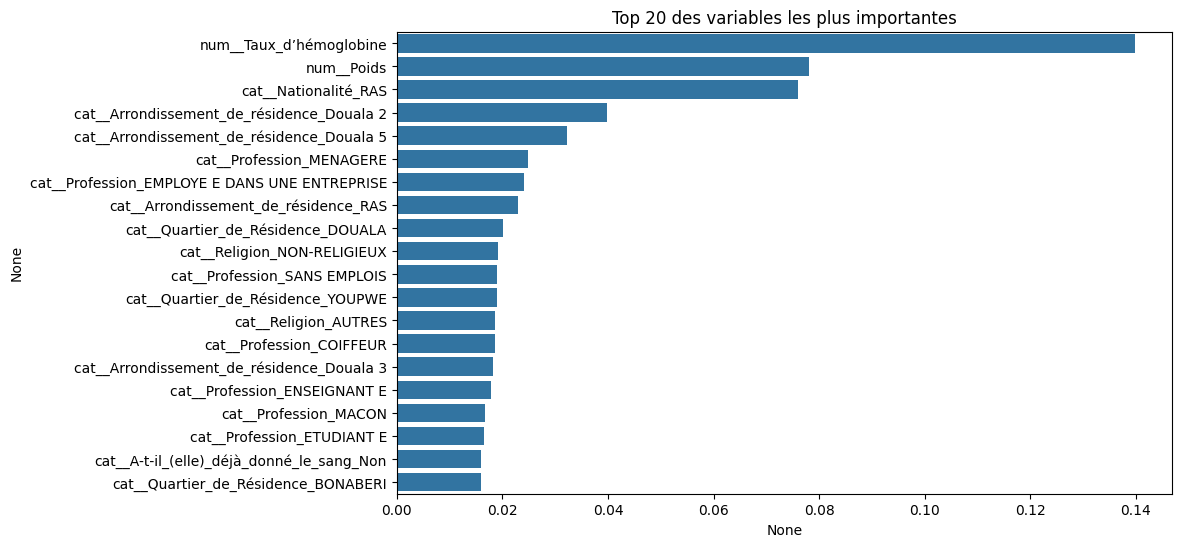

In [7]:
model = grid_search.best_estimator_.named_steps['classifier']
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 20 des variables les plus importantes")
plt.show()


## 🧠 Interprétation des variables les plus importantes

Le graphique ci-dessous met en évidence les **20 variables les plus déterminantes** dans la prédiction de l’éligibilité au don de sang, selon le modèle `XGBoost` :


### 🔍 Analyse des résultats

1. **Variables numériques dominantes** :
   - `Taux d’hémoglobine` et `Poids` sont de loin les plus influentes, ce qui est **cohérent médicalement**, car ces deux paramètres sont directement liés à l’aptitude au don de sang.
   - Cela valide la pertinence des **données cliniques** dans les prédictions.

2. **Variables catégorielles pertinentes** :
   - `Nationalité_RAS`, `Profession_MÉNAGÈRE`, `EMPLOYÉ`, `ENSEIGNANT`, etc., montrent que la **profession** ou certaines **informations sociogéographiques** influencent également les prédictions.
   - Les **arrondissements de résidence** apparaissent aussi souvent, ce qui peut refléter des **disparités géographiques** dans l’éligibilité (accès aux soins, sensibilisation, etc.).

3. **Éléments de comportement** :
   - La variable `A-t-il (elle) déjà donné le sang_Non` fait partie du top 20, ce qui suggère que l’**expérience antérieure de don** joue un rôle.



## 💾 Sauvegarde du modèle entraîné

Après avoir identifié le **meilleur modèle** via la recherche d’hyperparamètres (`GridSearchCV`), il est important de le **sauvegarder** pour une utilisation ultérieure sans avoir à le réentraîner.

### 🧱 Étapes de sauvegarde

1. **Extraction du meilleur estimateur**
   - `grid_search.best_estimator_` contient l’intégralité du pipeline optimal (prétraitement, équilibrage des classes, et classifieur entraîné).

2. **Sauvegarde avec `joblib`**
   - La bibliothèque `joblib` est utilisée pour sérialiser le modèle.
   - Le pipeline est enregistré dans un fichier nommé `modele_prediction.pkl`.

### 🧠 Pourquoi sauvegarder un modèle ?

- Pour le **réutiliser** plus tard dans une API ou une application web.
- Pour garantir la **reproductibilité** du modèle (mêmes performances, mêmes traitements).
- Pour faciliter la **mise en production** ou la **démo** sans devoir réexécuter tout le notebook.


In [8]:
import joblib

# Sauvegarder le meilleur modèle trouvé par GridSearchCV
best_model = grid_search.best_estimator_

# Sauvegarder le modèle dans un fichier
joblib.dump(best_model, 'modele_prediction.pkl')


['modele_prediction.pkl']

## 🧠 Explication du modèle avec SHAP

Pour comprendre les **décisions** prises par le modèle de classification, nous utilisons **SHAP (SHapley Additive exPlanations)**, une méthode d’explicabilité qui attribue une importance à chaque **feature** pour chaque **prédiction individuelle**.

### 🔍 Étapes de l’analyse SHAP

1. **Prétraitement des données de test**
   - Transformation des données via le préprocesseur du pipeline (`StandardScaler` + `OneHotEncoder`).
   - Conversion de la matrice de features en tableau dense si nécessaire.

2. **Récupération des noms de variables**
   - Concaténation des noms des variables numériques et des variables catégorielles encodées (après `OneHotEncoder`).

3. **Création de l'explainer**
   - Utilisation de `shap.Explainer()` sur le classifieur (`XGBClassifier`) pour générer les **valeurs SHAP**.

4. **Sélection d’une classe pour l’analyse**
   - En cas de classification multi-classes, on sélectionne une **classe cible** pour visualiser l’impact des features.

5. **Affichage du `summary_plot`**
   - Le **summary plot** permet de visualiser les variables les plus influentes sur la prédiction d’une classe donnée :
     - Couleur = valeur de la variable (rouge = élevée, bleu = faible).
     - Position horizontale = impact sur la prédiction (positif ou négatif).




Shape of shap_values: (575, 538, 3)
Shape of X_test_transformed: (575, 538)


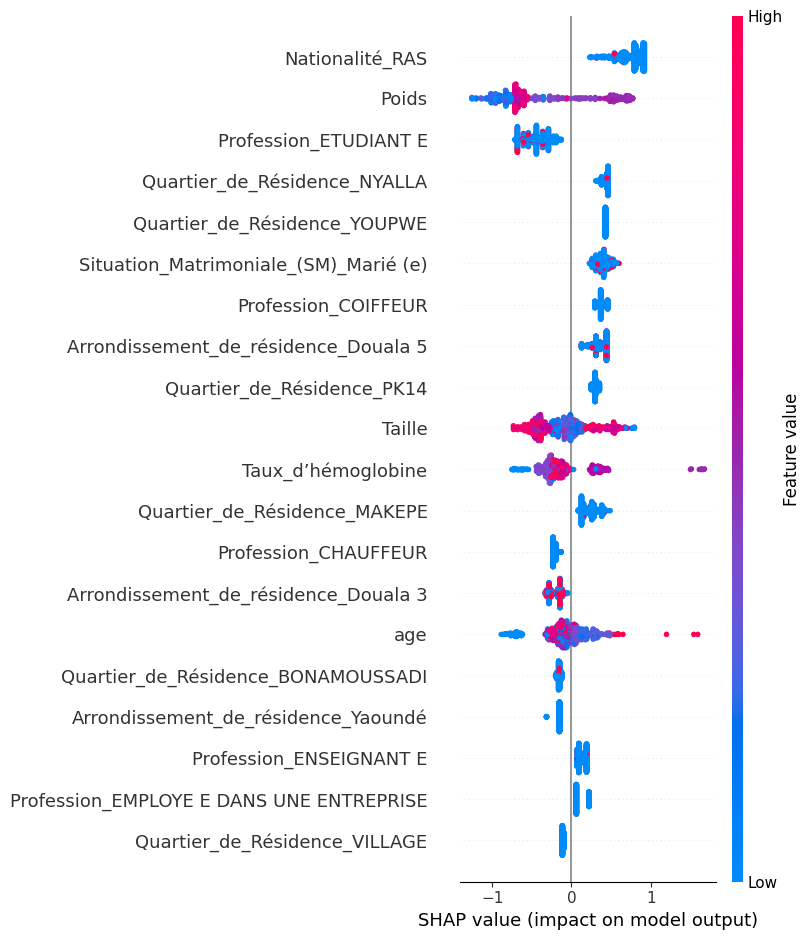

In [9]:
import shap
import numpy as np

# ----- SHAP ANALYSIS -----
# Extraire le meilleur modèle entraîné après GridSearchCV
best_model = grid_search.best_estimator_

# Appliquer le prétraitement aux données de test
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Vérifier et convertir en array dense si nécessaire
if hasattr(X_test_transformed, "toarray"):  # Vérifie si c'est une matrice sparse
    X_test_transformed = X_test_transformed.toarray()
else:
    X_test_transformed = np.array(X_test_transformed)

# Récupérer les noms des features après transformation
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_features)

# Construire la liste complète des noms des features après transformation
feature_names = list(numeric_features) + list(encoded_feature_names)

# Convertir X_test_transformed en numpy array si ce n'est pas déjà le cas
X_test_transformed = np.array(X_test_transformed)

# Créer un explainer SHAP
explainer = shap.Explainer(best_model.named_steps['classifier'])
shap_values = explainer(X_test_transformed)

# Vérifier la structure des valeurs SHAP
if isinstance(shap_values, shap.Explanation):
    shap_values_array = shap_values.values  # Extraire les valeurs SHAP
else:
    shap_values_array = shap_values  # Si déjà sous forme de tableau

print("Shape of shap_values:", shap_values_array.shape)  # (383, 583, 3) pour multiclasse
print("Shape of X_test_transformed:", X_test_transformed.shape)  # (383, 583)

# ✅ Correction : Sélection d'une classe spécifique pour le summary plot
class_index = 0  # Modifier si besoin pour afficher une autre classe
shap_values_class = shap_values_array[:, :, class_index]  # Extraction des SHAP pour une seule classe

# ---- 📊 Affichage des visualisations SHAP ----

# 1️⃣ Importance globale des features
shap.summary_plot(shap_values_class, X_test_transformed, feature_names=feature_names)




In [10]:
shap.initjs()  # 🔥 Initialise la bibliothèque JavaScript

# 2️⃣ Force plot pour une observation spécifique (ex: première instance)
shap.force_plot(
    explainer.expected_value[class_index],  
    shap_values_class[0], 
    X_test_transformed[0], 
    feature_names=feature_names
)